[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timz815/IAT360-CV-Project/blob/main/CVNotebook.ipynb)

In [ ]:
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu122

# GPU Check
import torch
print("GPU detected:", torch.cuda.device_count())

In [1]:
#pip3 install notebook
#pip3 install numpy pandas matplotlib tensorflow opencv-python seaborn pillow

# For local runtime, in cmd/terminal paste: jupyter notebook

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
import json
from pathlib import Path
import torch


In [3]:
# =========
# Load Data
# =========

# For MAC
#base_dir = "/Users/tim/Downloads/CV_dataset"

# For Windows
base_dir = r"C:\Users\timot\Downloads\CV_dataset"

ann_dir = os.path.join(base_dir, "ann")
img_dir = os.path.join(base_dir, "img")


# Check if dataset is correct, can comment out
print(f"Dataset Folder found: {os.path.exists(base_dir)}")
print(f"Images found: {sum(len(glob.glob(os.path.join(img_dir, f'*.{ext}'))) for ext in ['png','jpg','jpeg'])}")
print(f"Annotations found: {len(glob.glob(os.path.join(ann_dir, '*.txt')))}")


Dataset Folder found: True
Images found: 6523
Annotations found: 6523


In [4]:
# ==========
# Clean Data
# ==========

valid_pairs = []
image_files = (glob.glob(os.path.join(img_dir, "*.png")) +
               glob.glob(os.path.join(img_dir, "*.jpg")) +
               glob.glob(os.path.join(img_dir, "*.jpeg")))

for image_file in image_files:
    image_filename = os.path.basename(image_file)
    label_file = os.path.join(ann_dir, image_filename + ".txt")

    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            content = f.read().strip()

        if content:  # Simple check like fruit project
            valid_pairs.append((image_file, label_file))

print(f"Found {len(valid_pairs)} valid pairs")

NameError: name 'img_dir' is not defined

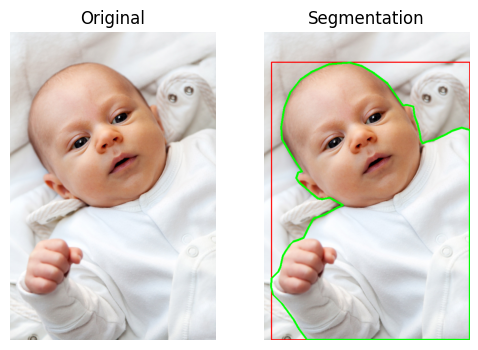

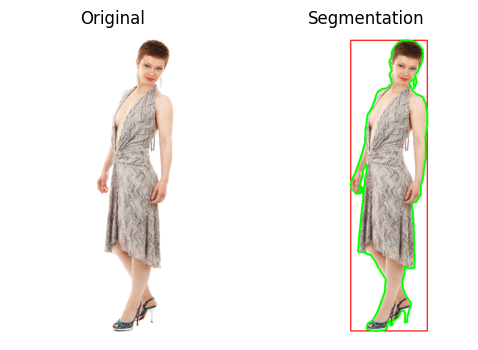

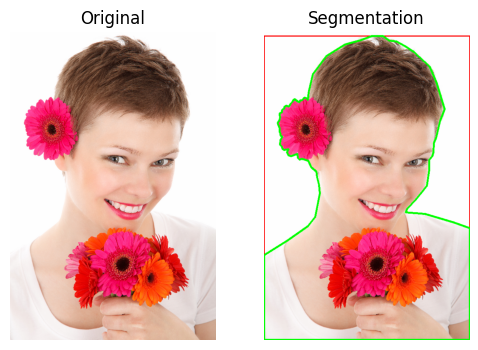

In [7]:
# ===================
# Visualization Check
# ===================

for i in range(min(3, len(valid_pairs))):
    image_path, ann_path = valid_pairs[i]

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    overlay = image.copy()

    with open(ann_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 6:
                # --- Bounding Box ---
                x_center = float(parts[1]) * width
                y_center = float(parts[2]) * height
                box_w = float(parts[3]) * width
                box_h = float(parts[4]) * height

                x1 = int(x_center - box_w/2)
                y1 = int(y_center - box_h/2)
                x2 = int(x_center + box_w/2)
                y2 = int(y_center + box_h/2)

                # Red Box
                cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)

                # --- Polygon Mask ---
                polygon_points = []
                for j in range(5, len(parts), 2):
                    if j + 1 < len(parts):
                        x = float(parts[j]) * width
                        y = float(parts[j + 1]) * height
                        polygon_points.append([x, y])

                if len(polygon_points) > 2:
                    pts = np.array(polygon_points, np.int32)
                    # Green Mask
                    cv2.polylines(overlay, [pts], True, (0, 255, 0), 3)

    # Display Config
    plt.figure(figsize=(6, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Segmentation")
    plt.axis('off')

    # Display
    plt.show()

In [8]:
# ==================
# Create YAML Config
# ==================

yaml_path = os.path.join(base_dir, "segmentation_config.yaml")
yaml_content = f"""
path: {os.path.join(base_dir, "Final_Seg_Data")}
train: images/train
val: images/val

# Number of classes
nc: 1

# Class names
names:
  0: person
"""

with open(yaml_path, 'w') as f:
    f.write(yaml_content)

In [9]:
# ===================
# Split and Copy Data
# ===================

base_output_dir = os.path.join(base_dir, "Final_Seg_Data")

train_images_dir = os.path.join(base_output_dir, "images/train")
if os.path.exists(train_images_dir) and len(os.listdir(train_images_dir)) > 0:
    print("Dataset already exists! Skipping file copying.")
    print(f"Found {len(os.listdir(train_images_dir))} images in train folder")
else:
    # Create new directories
    os.makedirs(os.path.join(base_output_dir, "images/train"), exist_ok=True)
    os.makedirs(os.path.join(base_output_dir, "images/val"), exist_ok=True)
    os.makedirs(os.path.join(base_output_dir, "labels/train"), exist_ok=True)
    os.makedirs(os.path.join(base_output_dir, "labels/val"), exist_ok=True)

    # Split data for training and val
    split_idx = int(len(valid_pairs) * 0.8)
    train_pairs = valid_pairs[:split_idx]
    val_pairs = valid_pairs[split_idx:]

    print(f"Training samples: {len(train_pairs)}")
    print(f"Validation samples: {len(val_pairs)}")

    # Copy training data
    for image_path, ann_path in train_pairs:
        filename = os.path.basename(image_path)
        shutil.copy2(image_path, os.path.join(base_output_dir, "images/train", filename))
        shutil.copy2(ann_path, os.path.join(base_output_dir, "labels/train", os.path.basename(ann_path)))

    # Copy validation data
    for image_path, ann_path in val_pairs:
        filename = os.path.basename(image_path)
        shutil.copy2(image_path, os.path.join(base_output_dir, "images/val", filename))
        shutil.copy2(ann_path, os.path.join(base_output_dir, "labels/val", os.path.basename(ann_path)))

    print("Data copied successfully!")

    # AUTO-RENAME LABEL FILES
    labels_train_dir = os.path.join(base_output_dir, "labels/train")
    labels_val_dir = os.path.join(base_output_dir, "labels/val")

    # Rename training labels
    train_fixed = 0
    for label_file in os.listdir(labels_train_dir):
        if '.jpeg.txt' in label_file:
            new_name = label_file.replace('.jpeg.txt', '.txt')
        elif '.jpg.txt' in label_file:
            new_name = label_file.replace('.jpg.txt', '.txt')
        elif '.png.txt' in label_file:
            new_name = label_file.replace('.png.txt', '.txt')
        else:
            continue

        old_path = os.path.join(labels_train_dir, label_file)
        new_path = os.path.join(labels_train_dir, new_name)
        os.rename(old_path, new_path)
        train_fixed += 1

    # Rename validation labels
    val_fixed = 0
    for label_file in os.listdir(labels_val_dir):
        if '.jpeg.txt' in label_file:
            new_name = label_file.replace('.jpeg.txt', '.txt')
        elif '.jpg.txt' in label_file:
            new_name = label_file.replace('.jpg.txt', '.txt')
        elif '.png.txt' in label_file:
            new_name = label_file.replace('.png.txt', '.txt')
        else:
            continue

        old_path = os.path.join(labels_val_dir, label_file)
        new_path = os.path.join(labels_val_dir, new_name)
        os.rename(old_path, new_path)
        val_fixed += 1

    # Print only if files were fixed
    if train_fixed > 0 or val_fixed > 0:
        print(f"Fixed {train_fixed} training labels and {val_fixed} validation labels")


Dataset already exists! Skipping file copying.
Found 4228 images in train folder


In [10]:
%pip install ultralytics
import ultralytics
ultralytics.checks()


Ultralytics 8.3.221  Python-3.13.1 torch-2.9.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
Setup complete  (24 CPUs, 29.7 GB RAM, 834.8/928.7 GB disk)


In [11]:
from ultralytics import YOLO

model = YOLO('yolov8s-seg.pt')
model.train(
    data=os.path.join(base_dir, "segmentation_config.yaml"),
    epochs=10,
    patience=10,  #test
    batch=8,
    lr0=0.0005,   #test
    imgsz=640,
    #device='cuda' #'auto'
)

Ultralytics 8.3.221  Python-3.13.1 torch-2.9.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\timot\Downloads\CV_dataset\segmentation_config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000025307CB1F40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0

In [2]:
# =====================
# Segmentation Analysis
# =====================

def convert_yolo_seg_to_mask(seg_points, image_width, image_height):
    """Convert YOLO segmentation points to binary mask"""
    # Convert normalized coordinates to pixel coordinates
    points = []
    for i in range(0, len(seg_points), 2):
        if i+1 < len(seg_points):
            x = seg_points[i] * image_width
            y = seg_points[i+1] * image_height
            points.append([x, y])

    # Create mask
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    if len(points) > 2:
        pts = np.array(points, dtype=np.int32)
        cv2.fillPoly(mask, [pts], 1)
    return mask

# Analyze segmentation quality
iou_scores = []
val_images = glob.glob(os.path.join(val_images_dir, "*"))[:10]  # Fewer for speed

for i, image_path in enumerate(val_images):
    if i % 5 == 0:
        print(f"Processing {i}/{len(val_images)} images for segmentation analysis...")

    # Load image for dimensions
    image = cv2.imread(image_path)
    if image is None:
        continue
    height, width = image.shape[:2]

    # Ground truth mask
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(val_labels_dir, f"{image_name}.txt")

    gt_mask = np.zeros((height, width), dtype=np.uint8)
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 6:  # Has segmentation points
                    seg_points = [float(x) for x in parts[5:]]
                    person_mask = convert_yolo_seg_to_mask(seg_points, width, height)
                    gt_mask = np.logical_or(gt_mask, person_mask)

    # Predicted mask
    results = model(image_path, conf=0.25, verbose=False)
    pred_mask = np.zeros((height, width), dtype=np.uint8)

    if len(results) > 0 and results[0].masks is not None:
        for mask_data in results[0].masks.data:
            # Resize predicted mask to original image size
            mask_resized = cv2.resize(mask_data.cpu().numpy(), (width, height))
            pred_mask = np.logical_or(pred_mask, mask_resized > 0.5)

    # Calculate IoU
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()
    iou = intersection / union if union > 0 else 0
    iou_scores.append(iou)

    # Visualize every 2nd image
    if i % 2 == 0 and iou > 0:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Original
        axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Ground Truth Mask
        axes[1].imshow(gt_mask, cmap='viridis')
        axes[1].set_title('Ground Truth Mask')
        axes[1].axis('off')

        # Predicted Mask
        axes[2].imshow(pred_mask, cmap='viridis')
        axes[2].set_title(f'Predicted Mask\nIoU: {iou:.3f}')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

# Segmentation Quality Summary
print(f"Average IoU: {np.mean(iou_scores):.3f}")
print(f"IoU Std: {np.std(iou_scores):.3f}")
print(f"Min IoU: {np.min(iou_scores):.3f}")
print(f"Max IoU: {np.max(iou_scores):.3f}")
print(f"Images with IoU > 0.7: {sum(iou > 0.7 for iou in iou_scores)}/{len(iou_scores)}")

NameError: name 'val_images_dir' is not defined

In [ ]:
# =====================
# Confusion Matrix
# =====================

def create_segmentation_confusion_matrix(model, val_images, val_labels_dir, num_images=20):
    """Create pixel-level confusion matrix for segmentation"""
    all_gt_pixels = []
    all_pred_pixels = []

    for i, image_path in enumerate(val_images[:num_images]):
        if i % 5 == 0:
            print(f"Processing {i}/{min(num_images, len(val_images))} images for pixel analysis...")

        # Load image
        image = cv2.imread(image_path)
        if image is None:
            continue
        height, width = image.shape[:2]

        # Ground truth mask
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        label_path = os.path.join(val_labels_dir, f"{image_name}.txt")

        gt_mask = np.zeros((height, width), dtype=np.uint8)
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 6:
                        seg_points = [float(x) for x in parts[5:]]
                        person_mask = convert_yolo_seg_to_mask(seg_points, width, height)
                        gt_mask = np.logical_or(gt_mask, person_mask)

        # Predicted mask
        results = model(image_path, conf=0.25, verbose=False)
        pred_mask = np.zeros((height, width), dtype=np.uint8)

        if len(results) > 0 and results[0].masks is not None:
            for mask_data in results[0].masks.data:
                mask_resized = cv2.resize(mask_data.cpu().numpy(), (width, height))
                pred_mask = np.logical_or(pred_mask, mask_resized > 0.5)

        # Flatten masks to 1D arrays for confusion matrix
        all_gt_pixels.extend(gt_mask.flatten())
        all_pred_pixels.extend(pred_mask.flatten())

    return np.array(all_gt_pixels), np.array(all_pred_pixels)

# Create pixel-level confusion matrix
print("Creating pixel-level confusion matrix...")
gt_pixels, pred_pixels = create_segmentation_confusion_matrix(
    model, val_images, val_labels_dir, num_images=30
)

# Calculate confusion matrix
cm = confusion_matrix(gt_pixels, pred_pixels)
cm_normalized = confusion_matrix(gt_pixels, pred_pixels, normalize='true')

labels = ['Background', 'Person']

# Create DataFrames
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_norm_df = pd.DataFrame(cm_normalized, index=labels, columns=labels)

# Plot confusion matrices
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            annot_kws={"size": 16, "weight": "bold"})
plt.title('Pixel-Level Confusion Matrix\n(Segmentation - Counts)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Pixel Class', fontsize=12, fontweight='bold')
plt.ylabel('True Pixel Class', fontsize=12, fontweight='bold')

plt.subplot(1, 2, 2)
sns.heatmap(cm_norm_df, annot=True, fmt='.2%', cmap='Blues', cbar=True,
            annot_kws={"size": 16, "weight": "bold"})
plt.title('Pixel-Level Confusion Matrix\n(Segmentation - Normalized)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Pixel Class', fontsize=12, fontweight='bold')
plt.ylabel('True Pixel Class', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate metrics
accuracy = accuracy_score(gt_pixels, pred_pixels)
precision = precision_score(gt_pixels, pred_pixels, average='binary', zero_division=0)
recall = recall_score(gt_pixels, pred_pixels, average='binary', zero_division=0)
f1 = f1_score(gt_pixels, pred_pixels, average='binary', zero_division=0)

print(f"{'Metric':<12} {'Score':<8} {'Percentage':<12}")
print("-" * 40)
print(f"{'Accuracy':<12} {accuracy:.4f}    {accuracy*100:>6.2f}%")
print(f"{'Precision':<12} {precision:.4f}    {precision*100:>6.2f}%")
print(f"{'Recall':<12} {recall:.4f}    {recall*100:>6.2f}%")
print(f"{'F1-Score':<12} {f1:.4f}    {f1*100:>6.2f}%")
print("-" * 40)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(gt_pixels, pred_pixels, target_names=labels, digits=4))

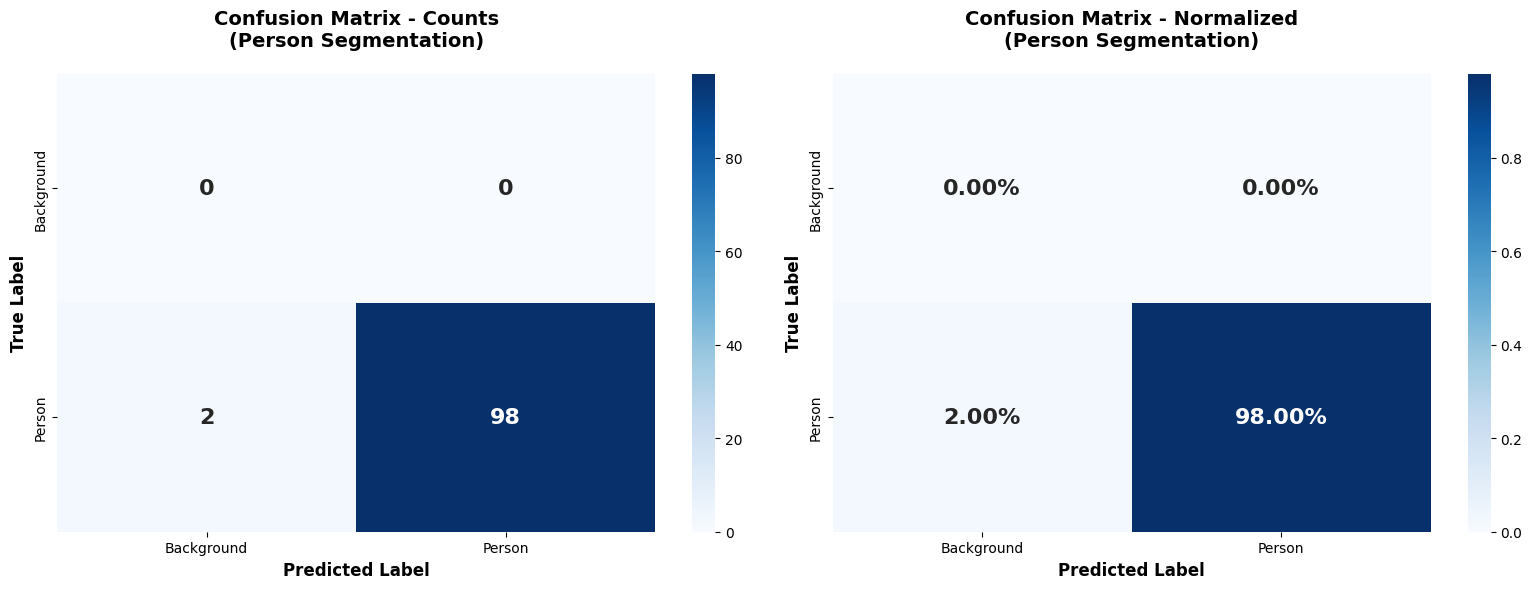

In [13]:
# =========
#  F1 Curve
# =========

def calculate_f1_at_thresholds(model, val_images, val_labels_dir, thresholds, num_images=15):
    """Calculate F1 scores at different confidence thresholds"""
    threshold_results = []

    for threshold in thresholds:
        print(f"Testing threshold {threshold:.2f}...")
        all_gt_pixels = []
        all_pred_pixels = []

        for image_path in val_images[:num_images]:
            # Load image
            image = cv2.imread(image_path)
            if image is None:
                continue
            height, width = image.shape[:2]

            # Ground truth mask
            image_name = os.path.splitext(os.path.basename(image_path))[0]
            label_path = os.path.join(val_labels_dir, f"{image_name}.txt")

            gt_mask = np.zeros((height, width), dtype=np.uint8)
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 6:
                            seg_points = [float(x) for x in parts[5:]]
                            person_mask = convert_yolo_seg_to_mask(seg_points, width, height)
                            gt_mask = np.logical_or(gt_mask, person_mask)

            # Predicted mask at current threshold
            results = model(image_path, conf=threshold, verbose=False)
            pred_mask = np.zeros((height, width), dtype=np.uint8)

            if len(results) > 0 and results[0].masks is not None:
                for mask_data in results[0].masks.data:
                    mask_resized = cv2.resize(mask_data.cpu().numpy(), (width, height))
                    pred_mask = np.logical_or(pred_mask, mask_resized > 0.5)

            # Add to overall arrays
            all_gt_pixels.extend(gt_mask.flatten())
            all_pred_pixels.extend(pred_mask.flatten())

        # Calculate metrics at this threshold
        if len(all_gt_pixels) > 0:
            accuracy = accuracy_score(all_gt_pixels, all_pred_pixels)
            precision_val = precision_score(all_gt_pixels, all_pred_pixels, average='binary', zero_division=0)
            recall_val = recall_score(all_gt_pixels, all_pred_pixels, average='binary', zero_division=0)
            f1_val = f1_score(all_gt_pixels, all_pred_pixels, average='binary', zero_division=0)

            threshold_results.append({
                'threshold': threshold,
                'accuracy': accuracy,
                'precision': precision_val,
                'recall': recall_val,
                'f1': f1_val
            })

    return threshold_results

# Test different thresholds
thresholds_to_test = np.arange(0.1, 0.9, 0.05)
print(f"Testing {len(thresholds_to_test)} thresholds...")
threshold_results = calculate_f1_at_thresholds(model, val_images, val_labels_dir, thresholds_to_test)

# Find optimal threshold
threshold_df = pd.DataFrame(threshold_results)
best_threshold_row = threshold_df.loc[threshold_df['f1'].idxmax()]
best_threshold = best_threshold_row['threshold']
best_f1 = best_threshold_row['f1']

print(f"\n🎯 Optimal Confidence Threshold: {best_threshold:.3f}")
print(f"🏆 Best F1-Score at this threshold: {best_f1:.3f}")

# Plot F1-Threshold Curve
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(threshold_df['threshold'], threshold_df['accuracy'], 'b-', linewidth=2, marker='o')
plt.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.title('Pixel Accuracy vs Threshold')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(threshold_df['threshold'], threshold_df['precision'], 'g-', linewidth=2, marker='o')
plt.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Confidence Threshold')
plt.ylabel('Precision')
plt.title('Pixel Precision vs Threshold')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(threshold_df['threshold'], threshold_df['recall'], 'orange', linewidth=2, marker='o')
plt.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Confidence Threshold')
plt.ylabel('Recall')
plt.title('Pixel Recall vs Threshold')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(threshold_df['threshold'], threshold_df['f1'], 'purple', linewidth=2, marker='o')
plt.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.7,
            label=f'Optimal: {best_threshold:.3f}')
plt.xlabel('Confidence Threshold')
plt.ylabel('F1-Score')
plt.title('Pixel F1-Score vs Threshold\n(Segmentation Quality)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Get precision-recall values
precision_vals, recall_vals, _ = precision_recall_curve(gt_pixels, pred_pixels)
f1_scores_curve = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(recall_vals, precision_vals, 'b-', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Pixel Precision-Recall Curve\n(Segmentation)')
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.plot(threshold_df['threshold'], threshold_df['f1'], 'purple', linewidth=2, marker='o')
plt.axvline(x=best_threshold, color='red', linestyle='--',
            label=f'Optimal: {best_threshold:.3f}')
plt.xlabel('Confidence Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold\n(Segmentation)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()